# Prepare the Data Directory Used for Pretraining and Fine-tuning

Author: Jonah Eaton
Date Updated: 2024-July-11
Notes:
- assumes metadata has already been cleaned for each study
- assumes that we already have some data prepared from previous pretraining

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Functions

In [2]:
import seaborn as sns
import umap
from sklearn.decomposition import PCA

def generate_pca_embedding(matrix, n_components=2):
    pca = PCA(n_components=n_components)
    embedding = pca.fit_transform(matrix.T)
    if isinstance(matrix, pd.DataFrame):
        embedding = pd.DataFrame(embedding, index=matrix.columns, columns=[f'PCA{i+1}' for i in range(n_components)])
    return embedding

def generate_umap_embedding(matrix, n_components=2):

    reducer = umap.UMAP(n_components=n_components)
    embedding = reducer.fit_transform(matrix.T)
    if isinstance(matrix, pd.DataFrame):
        embedding = pd.DataFrame(embedding, index=matrix.columns, columns=[f'UMAP{i+1}' for i in range(n_components)])
    return embedding

def plot_pca(embedding,metadata,col_name,yes_umap=False):

    if yes_umap:
        xvar = 'UMAP1'
        yvar = 'UMAP2'
    else:
        xvar = 'PCA1'
        yvar = 'PCA2'
    if metadata[col_name].nunique() < 10:
        palette = sns.color_palette("tab10", metadata[col_name].nunique())
        sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=metadata[col_name], palette=palette)
    else:
        sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=metadata[col_name])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=col_name)
    plt.xlabel(xvar)
    plt.ylabel(yvar)

    # add counts to the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    if metadata[col_name].nunique() < 15:
        labels = [f'{x} ({metadata[metadata[col_name]==x].shape[0]})' for x in labels]
        plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=col_name,
            ncol=2)  # ncol=2 makes the legend have 2 columns

    # add the number of samples to the title
    plt.title(f'N samples = {metadata[~metadata[col_name].isna()].shape[0]}')
    
def align_to_existing(input_intensity_matrix, pretrain_features, align_input, 
                      fill_na=False, std_scale=False, log2_scale=False,verbose=1,
                      full_missing_method='mean',partial_missing_method='mean',
                      fill_partial_missing_first=True):
    """
    Aligns input intensity matrix with pretrain features based on align input.

    Parameters:
    - input_intensity_matrix (pd.DataFrame): The input intensity matrix to align. Columns are features and rows are samples.
    - pretrain_features (list or pd.Index): The list or pd.Index of features used for pretraining (correspond to reference study features)
    - align_input (pd.DataFrame or pd.Series): The align input to use for alignment. has index of features from the reference study, 
    and values of the features from the input_intensity_matrix to align.
    - fill_na (bool, optional): Whether to fill missing values. Defaults to False. Missing values within the input study, 
        are filled by taking the average feature value, while features not present in the input study are filled by taking the average sample value.
    - std_scale (bool, optional): Whether to standardize the intensity matrix. Defaults to False.
    - log2_scale (bool, optional): Whether to log2 transform the intensity matrix. Defaults to False.
    - verbose (int, optional): The verbosity level. Defaults to 1.
    - full_missing_method (str, optional): The method to fill full missing values. Defaults to 'mean'. Options are 'mean', 'median', 'zero'.
    - partial_missing_method (str, optional): The method to fill partial missing values. Defaults to 'mean'. Options are 'mean', 'median'.
    - fill_partial_missing_first (bool, optional): Whether to fill partial missing values first. Defaults to True.


    Returns:
    - intensity_df (pd.DataFrame): The aligned intensity matrix.
    - nan_df (pd.DataFrame): A boolean DataFrame indicating missing values in the aligned intensity matrix.
    """
    if not isinstance(input_intensity_matrix, pd.DataFrame):
        raise ValueError('input_intensity_matrix should be a pandas DataFrame')

    if 'FT' not in input_intensity_matrix.columns[0][:2]:
        input_intensity_matrix = input_intensity_matrix.T

    if isinstance(align_input,pd.DataFrame):
        align_input = align_input.iloc[:,0].copy()

    common_pretrained_features = list(set(pretrain_features).intersection(align_input.index))
    if verbose > 1: print('Common pretrained features:', common_pretrained_features)
    if verbose > 0: print('number of common pretrained features:', len(common_pretrained_features))
    missing_pretrained_features = list(set(pretrain_features).difference(align_input.index))
    if verbose > 1: print('Missing pretrained features:', missing_pretrained_features)
    if verbose > 0: print('number of missing pretrained features:', len(missing_pretrained_features))
    align_input = align_input[common_pretrained_features].copy()
    
    input_features_aligned = align_input.values.tolist()
    pretrain_features_aligned = align_input.index.tolist()
    if isinstance(pretrain_features, pd.Index):
        pretrain_features = pretrain_features.tolist()
    

    output_matrix = np.empty((input_intensity_matrix.shape[0], len(pretrain_features)), dtype=float)
    output_matrix = output_matrix * np.nan
    output_matrix[:, [pretrain_features.index(f) for f in pretrain_features_aligned]] = input_intensity_matrix[input_features_aligned].values

    intensity_df = pd.DataFrame(output_matrix, index=input_intensity_matrix.index, columns=pretrain_features)
    nan_df = intensity_df.isnull()

    if log2_scale:
        intensity_df = np.log2(intensity_df + 1)

    if std_scale:
        scaler = StandardScaler()
        intensity_df = pd.DataFrame(scaler.fit_transform(intensity_df), index=intensity_df.index, columns=intensity_df.columns)
        
    if fill_na:
        # Fill partial missing values with the mean of the feature
        feats = intensity_df.columns
        full_missing_feats = feats[intensity_df.isna().sum(axis=0) == intensity_df.shape[0]]
        partial_missing_feats = feats[intensity_df.isna().sum(axis=0) < intensity_df.shape[0]]
        
        partial_missing = intensity_df.loc[:,partial_missing_feats].copy()

        if fill_partial_missing_first:
            if verbose>0: print('Warning: inpute the NA of the partial missing values first, may impact how the full missing values are filled')
            if partial_missing_method == 'mean':
                partial_missing.fillna(partial_missing.mean(), inplace=True)
            elif partial_missing_method == 'median':
                partial_missing.fillna(partial_missing.median(), inplace=True)
            else:
                raise ValueError('partial_missing_method of {} is not yet supported'.format(partial_missing_method))

        if full_missing_method == 'mean':
            full_missing = intensity_df.loc[:,full_missing_feats].copy()
            full_missing = full_missing.T
            full_missing.fillna(partial_missing.mean(axis=1), inplace=True)
            full_missing = full_missing.T
        elif full_missing_method == 'median':
            full_missing = intensity_df.loc[:,full_missing_feats].copy()
            full_missing = full_missing.T
            full_missing.fillna(partial_missing.median(axis=1), inplace=True)
            full_missing = full_missing.T
        elif full_missing_method == 'zero':
            full_missing = intensity_df.loc[:,full_missing_feats].copy()
            full_missing.fillna(0, inplace=True)

        if not fill_partial_missing_first:
            # do this after so we don't the filling of the "full-missing" is not impacted by how we fill the partial missing
            if partial_missing_method == 'mean':
                partial_missing.fillna(partial_missing.mean(), inplace=True)
            elif partial_missing_method == 'median':
                partial_missing.fillna(partial_missing.median(), inplace=True)
            else:
                raise ValueError('partial_missing_method of {} is not yet supported'.format(partial_missing_method))

        intensity_df = pd.concat([partial_missing, full_missing], axis=1)
    

    return intensity_df, nan_df

## Set up the Pretraining info

### Get the list of features used for pretraining

In [3]:
#Load the pretrained features corresponding to the Ref Study (ST001237)
pretrain_feats_file = 'pretrain_feats.txt'
pretrain_feats = pd.read_csv(pretrain_feats_file, header=None)[0].tolist()

In [4]:
# x_rcc_test_file = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/April_30_Finetune_Data/X_finetune_test.csv'
# x_rcc_test = pd.read_csv(x_rcc_test_file, index_col=0)
# pretrain_feats = x_rcc_test.columns

# # save the pretrain features to a list
# pretrain_feats_file = 'pretrain_feats.txt'
# with open(pretrain_feats_file, 'w') as f:
#     for item in pretrain_feats:
#         f.write("%s\n" % item)

In [5]:
# The base directory for saving stuff
# SAVE_BASE_DIR = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/July_09_Data2'
# SAVE_BASE_DIR = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/mzLearn_preTraining/data_2024_July_10'

SAVE_BASE_DIR = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/mzLearn_preTraining/data_2024_July_11' #Leila owns the mzlearn_preTraining folder
os.makedirs(SAVE_BASE_DIR, exist_ok=True)
clean_metadata_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/mzLearn_preTraining/source_metadata/metadata_2025_july_05'

## Example #1 with Stanford BMI

### Load the new study to be added to the pretraining with the metadata

In [6]:
data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/stanford-hmp2'
metab_study_name = 'stanford-hmp2'
new_alignment_df = pd.read_csv(f'{data_dir}/alignment_df.csv', index_col=0)
new_alignment_df.dropna(axis=0, how='all', inplace=True)
cohort_align = new_alignment_df['627'].copy()

In [7]:

# metadata = pd.read_csv(f'{standford_data_dir}/stanford-hmp2_metadata.tsv', index_col=0, sep='\t')

# metadata['file name'] = metadata.index
# metadata['mzml_file'] = metadata['file name'].apply(lambda x: x+'.mzML')
# metadata.index = metadata['mzml_file']

sample_info = pd.read_csv(f'{data_dir}/sample_info.csv', index_col=0)
metadata = pd.read_csv(f'{clean_metadata_dir}/metadata_{metab_study_name}.csv', index_col=0)
metadata =sample_info.join(metadata,how='left')

In [9]:
# save_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
# os.makedirs(save_dir, exist_ok=True)
# metadata.to_csv(f'{save_dir}/metadata.csv')

In [10]:
metadata

,timestamp,Ref,runtime_hour,batch_id,run_order,Column,Polarity,BMI,Race,Subject ID,Age,Cancer Risk,Diagnosis,is Pediatric,Cohort Label v0,Study ID,Job ID
file_name,,,,,,,,,,,,,,,,,
HILIC-pos-B1_MixAA_Mix.mzML,2016-12-14 20:22:40,0,0.000000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HILIC-pos-B1_MixOrgAcids_MixOthers.mzML,2016-12-14 20:49:28,0,0.446667,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HILIC-pos-B1_Mix1.mzML,2016-12-14 21:16:12,0,0.892222,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HILIC-pos-B1_Mix2.mzML,2016-12-14 21:42:57,0,1.338056,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HILIC-pos-B1_QC_dln2.mzML,2016-12-15 02:10:12,0,5.792222,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Exercise_HILIC-pos_ZPEL6L3-E18.mzML,2017-08-10 23:58:56,0,5739.604444,2,972,Hilic,Positive,24.44,C,ZPEL6L3,52.33,False,Exercise,False,adult_other,stanford-hmp2,627.0
Exercise_HILIC-pos_ZJBOZ2X-E13.mzML,2017-08-11 00:25:39,0,5740.049722,2,973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exercise_HILIC-pos_ZWFDEY0-E18.mzML,2017-08-11 00:52:19,0,5740.494167,2,974,Hilic,Positive,30.79,A,ZWFDEY0,62.92,False,Exercise,False,adult_other,stanford-hmp2,627.0


#### Align the input study to the pretraining features

In [11]:

norm_intensity = pd.read_csv(f'{data_dir}/final_peaks_intensity_max_pool_map_norm.csv', index_col=0)
intensity_df, nan_df = align_to_existing(norm_intensity.T, pretrain_feats, cohort_align, fill_na=True, std_scale=True, log2_scale=True,
                    full_missing_method='mean', partial_missing_method='mean', fill_partial_missing_first=True)

number of common pretrained features: 1767
number of missing pretrained features: 969


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


### Visualize results to confirm that the new study is properly normalized

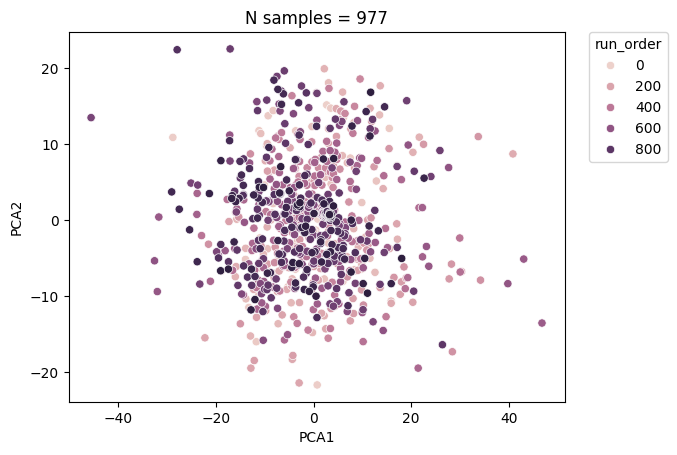

In [12]:
embedding0 = generate_pca_embedding(intensity_df.T).values

plot_pca(embedding0,metadata,col_name='run_order',yes_umap=False)

### Save the prepared study to be used for pretraining

In [13]:
# save the data 
save_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
os.makedirs(save_dir, exist_ok=True)
intensity_df.to_csv(f'{save_dir}/scaled_intensity_matrix.csv')
nan_df.to_csv(f'{save_dir}/nan_matrix.csv')
metadata.to_csv(f'{save_dir}/metadata.csv')

## Shanghai Lung Cancer

In [14]:
data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/MS_Data/ST002773_Shanghai_LungCancer'
metab_study_name = 'ST002773'

# the poolmap intensity matrix has already been matched to the pretrain features
# alignment_df = pd.read_csv(f'{data_dir}/alignment_df.csv', index_col=0)
# alignment_df.dropna(axis=0, how='all', inplace=True)

norm_intensity = pd.read_csv(f'{data_dir}/combined/final_peaks/intensity_max_pool.csv', index_col=0)

In [15]:
sample_info = pd.read_csv(f'{data_dir}/combined/sample_info/sample_info.csv', index_col=0)
metadata = pd.read_csv(f'{clean_metadata_dir}/metadata_{metab_study_name}.csv', index_col=0)
metadata['Ref']= 0
metadata.loc[metadata['Sample_Class']=='PooledQAQC','Ref'] = 1
metadata =metadata.join(sample_info[['run_order']],how='left')



# metadata = pd.read_csv(f'{data_dir}/metadata_complete.csv', index_col=0)
# metadata = metadata.loc[norm_intensity.columns].copy()
# metadata['Ref'] = metadata['Pool'].astype(int)
# metadata['batch_id'] = metadata['Batch'].astype(int)

In [16]:
cohort_align = pd.Series(norm_intensity.index, index=norm_intensity.index) #already aligned, so just use the index
intensity_df, nan_df = align_to_existing(norm_intensity.T, pretrain_feats, cohort_align, fill_na=True, std_scale=True, log2_scale=True,
                                            full_missing_method='mean', partial_missing_method='mean', fill_partial_missing_first=True)

number of common pretrained features: 1400
number of missing pretrained features: 1336


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


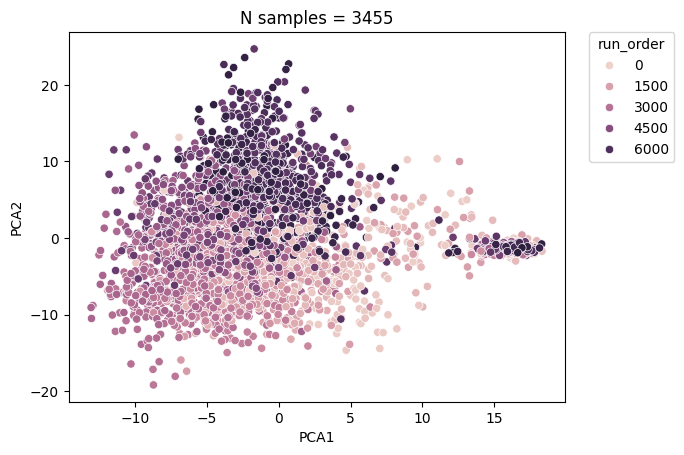

In [17]:
embedding0 = generate_pca_embedding(intensity_df.T).values

plot_pca(embedding0,metadata,col_name='run_order',yes_umap=False)

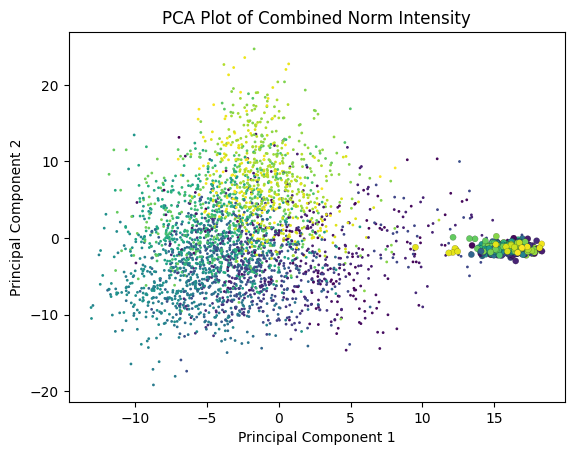

In [18]:
run_order = metadata.loc[intensity_df.index,'run_order'].values
ref_samples = metadata.loc[intensity_df.index,'Ref'].values
color_norm = plt.Normalize(vmin=0, vmax=metadata['run_order'].max())

# Create PCA plot
plt.scatter(embedding0[:, 0], embedding0[:, 1], c=run_order, cmap='viridis', s=1, norm=color_norm)

plt.scatter(embedding0[:, 0][ref_samples.astype(bool)], 
            embedding0[:, 1][ref_samples.astype(bool)], 
            c=run_order[ref_samples.astype(bool)], cmap='viridis', 
            s=20, norm=color_norm, edgecolors='black', linewidths=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Combined Norm Intensity')
plt.show()

In [19]:
# save the data 
save_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
os.makedirs(save_dir, exist_ok=True)
intensity_df.to_csv(f'{save_dir}/scaled_intensity_matrix.csv')
nan_df.to_csv(f'{save_dir}/nan_matrix.csv')
metadata.to_csv(f'{save_dir}/metadata.csv')

## ST000601
Untargeted LC-MS metabolomics analysis of human COPD plasma
correspond to cohort id 547


In [20]:
org_alignment_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/alignment_id_36/grid_search_index_1/'
alignment_df = pd.read_csv(f'{org_alignment_dir}/alignment_df.csv', index_col=0)

In [21]:
metab_study_name = 'ST000601'
data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/MS_Data/ST000601/job_id_547'
cohort_id = 547
cohort_align = alignment_df[f'{cohort_id}'].dropna()

In [22]:
sample_info = pd.read_csv(f'{data_dir}/sample_info/sample_info.csv', index_col=0)
metadata_file = os.path.join(clean_metadata_dir, f'metadata_{metab_study_name}.csv')
metadata = pd.read_csv(metadata_file, index_col=0)
metadata = sample_info.join(metadata, how='left')


# cleaned_metadata_file = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/mzLearn_preTraining/source_metadata/metadata_2025_july_05/metadata_ST000601.csv'
# sample_info = pd.read_csv(f'{data_dir}/sample_info/sample_info.csv', index_col=0)

# metadata = pd.read_csv(cleaned_metadata_file, index_col=0)
# metadata = sample_info.join(metadata)

metadata.loc[metadata['Sex'].isna(),'Ref'] = 1

In [23]:
norm_intensity = pd.read_csv(f'{data_dir}/final_peaks/intensity_max_synthetic_map_norm.csv', index_col=0)

intensity_df, nan_df = align_to_existing(norm_intensity.T, pretrain_feats, cohort_align, fill_na=True, std_scale=True, log2_scale=True,
                                            full_missing_method='mean', partial_missing_method='mean', fill_partial_missing_first=True)

number of common pretrained features: 470
number of missing pretrained features: 2266


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


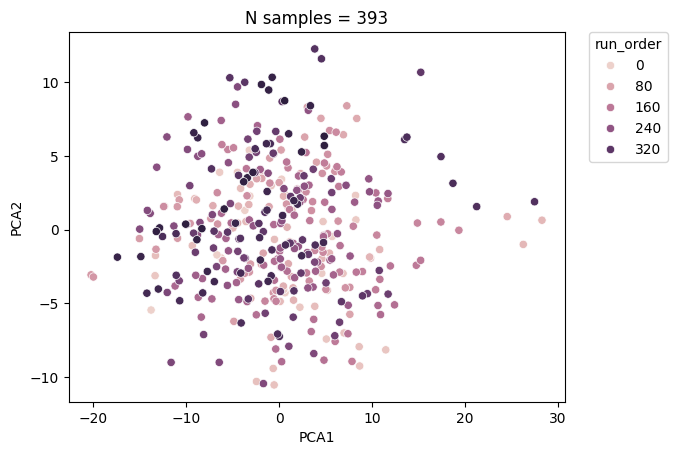

In [24]:
embedding0 = generate_pca_embedding(intensity_df.T).values

plot_pca(embedding0,metadata,col_name='run_order',yes_umap=False)

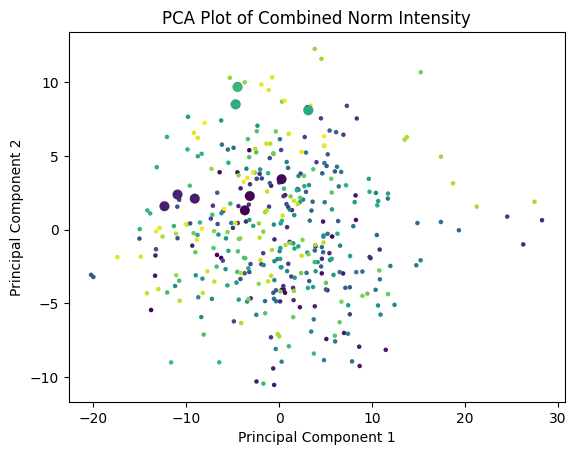

In [25]:
run_order = metadata.loc[intensity_df.index,'run_order'].values
ref_samples = metadata.loc[intensity_df.index,'Ref'].values
color_norm = plt.Normalize(vmin=0, vmax=metadata['run_order'].max())

# Create PCA plot
plt.scatter(embedding0[:, 0], embedding0[:, 1], c=run_order, cmap='viridis', s=5, norm=color_norm)

plt.scatter(embedding0[:, 0][ref_samples.astype(bool)], 
            embedding0[:, 1][ref_samples.astype(bool)], 
            c=run_order[ref_samples.astype(bool)], cmap='viridis', 
            s=50, norm=color_norm, edgecolors='black', linewidths=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Combined Norm Intensity')
plt.show()

In [26]:
# save the data 
save_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
os.makedirs(save_dir, exist_ok=True)
intensity_df.to_csv(f'{save_dir}/scaled_intensity_matrix.csv')
nan_df.to_csv(f'{save_dir}/nan_matrix.csv')
metadata.to_csv(f'{save_dir}/metadata.csv')

## ST001422
Previously I think I was too quick to remove outliers from this dataset. 
between these two studies, there are another 94 samples that have Sex
with 48 of those having Age, BMI and cancer information. So we will add these samples back in.

ST001422 corresponds to job ids: 502, 618


When mzlearn was run, we did not know which files were reference. now that we do we could run pool map normalizaiton instead of using synthetic norm

In [27]:
org_alignment_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/alignment_id_36/grid_search_index_1/'
alignment_df = pd.read_csv(f'{org_alignment_dir}/alignment_df.csv', index_col=0)

In [28]:
data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/MS_Data/ST001422/job_id_502'
cohort_id = 502
metab_study_name = 'ST001422'

cohort_align = alignment_df[f'{cohort_id}'].dropna()

In [29]:
sample_info = pd.read_csv(f'{data_dir}/sample_info/sample_info.csv', index_col=0)
metadata_file = os.path.join(clean_metadata_dir, f'metadata_{metab_study_name}.csv')
metadata = pd.read_csv(metadata_file, index_col=0)
metadata = sample_info.join(metadata, how='left')
metadata.loc[metadata['Sample_Class']=='Study_QC_Sample','Ref'] = 1

In [30]:
norm_intensity = pd.read_csv(f'{data_dir}/final_peaks/intensity_max_synthetic_map_norm.csv', index_col=0)

intensity_df, nan_df = align_to_existing(norm_intensity.T, pretrain_feats, cohort_align, fill_na=True, std_scale=True, log2_scale=True,
                                            full_missing_method='mean', partial_missing_method='mean', fill_partial_missing_first=True)

number of common pretrained features: 1606
number of missing pretrained features: 1130


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [31]:
embedding0 = generate_pca_embedding(intensity_df.T).values

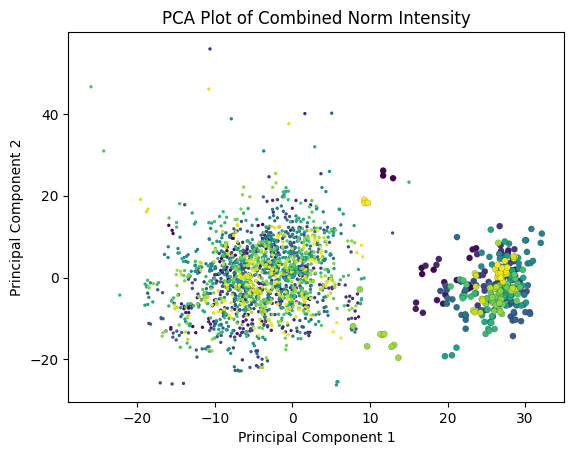

In [32]:
run_order = metadata.loc[intensity_df.index,'run_order'].values
ref_samples = metadata.loc[intensity_df.index,'Ref'].values
color_norm = plt.Normalize(vmin=0, vmax=metadata['run_order'].max())
marker_size = 2

# Create PCA plot
plt.scatter(embedding0[:, 0], embedding0[:, 1], c=run_order, cmap='viridis', s=marker_size, norm=color_norm)

plt.scatter(embedding0[:, 0][ref_samples.astype(bool)], 
            embedding0[:, 1][ref_samples.astype(bool)], 
            c=run_order[ref_samples.astype(bool)], cmap='viridis', 
            s=10*marker_size, norm=color_norm, edgecolors='black', linewidths=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Combined Norm Intensity')
plt.show()

In [33]:
# save the data 
save_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
os.makedirs(save_dir, exist_ok=True)
intensity_df.to_csv(f'{save_dir}/scaled_intensity_matrix.csv')
nan_df.to_csv(f'{save_dir}/nan_matrix.csv')
metadata.to_csv(f'{save_dir}/metadata.csv')

## ST001423

Previously I think I was too quick to remove outliers from this dataset. 
between these two studies, there are another 94 samples that have Sex
with 48 of those having Age, BMI and cancer information. So we will add these samples back in.

ST001423 corresponds to job ids: 526,  619

When mzlearn was run, we did not know which files were reference. now that we do we could run pool map normalizaiton instead of using synthetic norm

In [34]:
org_alignment_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/alignment_id_36/grid_search_index_1/'
alignment_df = pd.read_csv(f'{org_alignment_dir}/alignment_df.csv', index_col=0)

In [35]:
data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/MS_Data/ST001423/job_id_526'
cohort_id = 526
metab_study_name = 'ST001423'
cohort_align = alignment_df[f'{cohort_id}'].dropna()


In [36]:
sample_info = pd.read_csv(f'{data_dir}/sample_info/sample_info.csv', index_col=0)
metadata_file = os.path.join(clean_metadata_dir, f'metadata_{metab_study_name}.csv')
metadata = pd.read_csv(metadata_file, index_col=0)
metadata = sample_info.join(metadata, how='left')
metadata.loc[metadata['Sample_Class']=='Study_QC_Sample','Ref'] = 1

In [37]:
norm_intensity = pd.read_csv(f'{data_dir}/final_peaks/intensity_max_synthetic_norm.csv', index_col=0)

intensity_df, nan_df = align_to_existing(norm_intensity.T, pretrain_feats, cohort_align, fill_na=True, std_scale=True, log2_scale=True,
                                            full_missing_method='mean', partial_missing_method='mean', fill_partial_missing_first=True)

number of common pretrained features: 1601
number of missing pretrained features: 1135


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [38]:
embedding0 = generate_pca_embedding(intensity_df.T).values

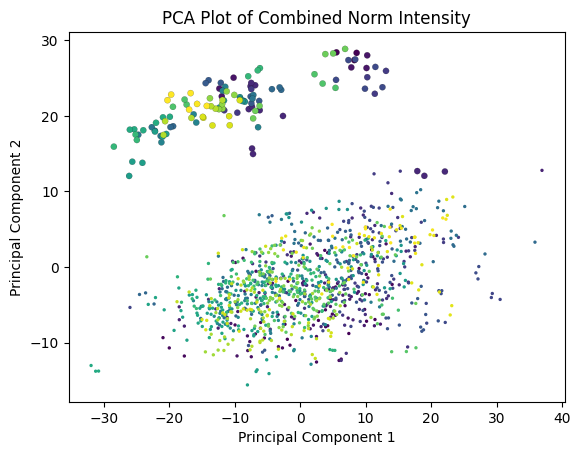

In [39]:
run_order = metadata.loc[intensity_df.index,'run_order'].values
ref_samples = metadata.loc[intensity_df.index,'Ref'].values
color_norm = plt.Normalize(vmin=0, vmax=metadata['run_order'].max())
marker_size = 2

# Create PCA plot
plt.scatter(embedding0[:, 0], embedding0[:, 1], c=run_order, cmap='viridis', s=marker_size, norm=color_norm)

plt.scatter(embedding0[:, 0][ref_samples.astype(bool)], 
            embedding0[:, 1][ref_samples.astype(bool)], 
            c=run_order[ref_samples.astype(bool)], cmap='viridis', 
            s=10*marker_size, norm=color_norm, edgecolors='black', linewidths=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Combined Norm Intensity')
plt.show()

In [40]:
# save the data 
save_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
os.makedirs(save_dir, exist_ok=True)
intensity_df.to_csv(f'{save_dir}/scaled_intensity_matrix.csv')
nan_df.to_csv(f'{save_dir}/nan_matrix.csv')
metadata.to_csv(f'{save_dir}/metadata.csv')

## Break apart the previous combined aligned dataset

In [41]:
previous_alignment_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/alignment_id_36/grid_search_index_1'

previous_intensity_file = f"{previous_alignment_dir}/subset_robust_Freq, Cohort Log Size Weighted_0.2_rem_['549', '551', '547']_recompute/X.csv"
previous_nans_file = f"{previous_alignment_dir}/subset_robust_Freq, Cohort Log Size Weighted_0.2_rem_['549', '551', '547']_recompute/nans.csv"
previous_metadata_file = f"{previous_alignment_dir}/subset_robust_Freq, Cohort Log Size Weighted_0.2_rem_['549', '551', '547']_recompute/y.csv"
previous_metadata = pd.read_csv(previous_metadata_file, index_col=0)


In [85]:
# rcc_metadata_file = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/rcc_result/clean_metadata_encoded.csv'
rcc_metadata_file = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/April_30_Finetune_Data/metadata.csv'
rcc_metadata = pd.read_csv(rcc_metadata_file, index_col=0)

In [86]:
rcc_metadata.columns

Index(['cohort_id', 'Study ID', 'Cohort Label', 'Cohort ID', 'OS', 'OS_Event',
       'Age', 'subject ID', 'study_week', 'Region', 'Sex', 'Race',
       'Dose (mg/kg)', 'phase', 'Treatment', 'Prior_2', 'batch_id',
       'runtime_hour', 'run_order', 'MSKCC', 'ORR', 'Benefit',
       'ExtremeResponder', 'PFS', 'PFS_Event', 'MV', 'Age_Group',
       'Benefit BINARY', 'Benefit ORDINAL', 'Nivo Benefit BINARY',
       'MSKCC BINARY', 'MSKCC ORDINAL', 'Matt Set', 'Set', 'Pretrain',
       'is Pediatric', 'Cohort Label ENC', 'Study ID ENC', 'file id',
       'Age Range (min)', 'Age Range (max)', 'IMDC', 'IMDC ORDINAL',
       'IMDC BINARY', 'is Female'],
      dtype='object')

In [87]:
# Add other columns for the RCC metadata
# rcc_metadata['IMDC BINARY'] = None
# rcc_metadata['IMDC BINARY'] = rcc_metadata['IMDC'].map({'FAVORABLE': 1, 'POOR': 0})

# rcc_metadata['IMDC ORDINAL'] = None
# rcc_metadata['IMDC ORDINAL'] = rcc_metadata['IMDC'].map({'FAVORABLE': 2, 'POOR': 0, 'INTERMEDIATE': 1})

rcc_metadata['NIVO OS'] = rcc_metadata['OS'].copy()
rcc_metadata.loc[rcc_metadata['Treatment']=='EVEROLIMUS','NIVO OS'] = np.nan

rcc_metadata['EVER OS'] = rcc_metadata['OS'].copy()
rcc_metadata.loc[rcc_metadata['Treatment']=='NIVOLUMAB','EVER OS'] = np.nan

In [88]:
print(previous_metadata.columns)

Index(['cohort_id', 'Study ID', 'Cohort Label', 'Cohort ID Expanded',
       'Study ID Expanded', 'Cohort ID', 'OS', 'OS_Event', 'Age', 'subject ID',
       'study_week', 'Region', 'Sex', 'Race', 'Dose (mg/kg)', 'phase',
       'Treatment', 'Prior_2', 'batch_id', 'runtime_hour', 'run_order',
       'MSKCC', 'ORR', 'Benefit', 'ExtremeResponder', 'PFS', 'PFS_Event', 'MV',
       'Age_Group', 'Benefit BINARY', 'Benefit ORDINAL', 'Nivo Benefit BINARY',
       'MSKCC BINARY', 'MSKCC ORDINAL', 'Matt Set', 'Set', 'Previous Study ID',
       'Previous Job ID', 'Matt Set Label', 'Previous Set',
       'Previous run_order', 'Previous MV'],
      dtype='object')


In [89]:
print(rcc_metadata.columns)

Index(['cohort_id', 'Study ID', 'Cohort Label', 'Cohort ID', 'OS', 'OS_Event',
       'Age', 'subject ID', 'study_week', 'Region', 'Sex', 'Race',
       'Dose (mg/kg)', 'phase', 'Treatment', 'Prior_2', 'batch_id',
       'runtime_hour', 'run_order', 'MSKCC', 'ORR', 'Benefit',
       'ExtremeResponder', 'PFS', 'PFS_Event', 'MV', 'Age_Group',
       'Benefit BINARY', 'Benefit ORDINAL', 'Nivo Benefit BINARY',
       'MSKCC BINARY', 'MSKCC ORDINAL', 'Matt Set', 'Set', 'Pretrain',
       'is Pediatric', 'Cohort Label ENC', 'Study ID ENC', 'file id',
       'Age Range (min)', 'Age Range (max)', 'IMDC', 'IMDC ORDINAL',
       'IMDC BINARY', 'is Female', 'NIVO OS', 'EVER OS'],
      dtype='object')


In [90]:
new_rcc_cols = ['Matt Set','Set','NIVO OS', 'EVER OS'] + [x for x in rcc_metadata.columns if 'BINARY' in x] + [x for x in rcc_metadata.columns if 'ORDINAL' in x]
print('update or add the following columns to the previous metadata:')
print(new_rcc_cols)

update or add the following columns to the previous metadata:
['Matt Set', 'Set', 'NIVO OS', 'EVER OS', 'Benefit BINARY', 'Nivo Benefit BINARY', 'MSKCC BINARY', 'IMDC BINARY', 'Benefit ORDINAL', 'MSKCC ORDINAL', 'IMDC ORDINAL']


In [91]:
previous_metadata.loc[rcc_metadata.index,new_rcc_cols] = rcc_metadata.loc[rcc_metadata.index,new_rcc_cols]

In [92]:
previous_metadata

,cohort_id,Study ID,Cohort Label,Cohort ID Expanded,Study ID Expanded,Cohort ID,OS,OS_Event,Age,subject ID,...,Previous Study ID,Previous Job ID,Matt Set Label,Previous Set,Previous run_order,Previous MV,NIVO OS,EVER OS,IMDC BINARY,IMDC ORDINAL
VT_171028_M314_167.mzML,556,ST000909,pediatric_CMD,556,ST000909,556,NaN,NaN,NaN,NaN,...,ST000909,556,NaN,Pretrain,NaN,89.967165,NaN,NaN,NaN,NaN
VT_170729_M021_175.mzML,559,ST001918,adult_other,559,ST001918,559,NaN,NaN,NaN,NaN,...,ST001918,559,NaN,Pretrain,NaN,89.821233,NaN,NaN,NaN,NaN
YW_200307_M431_189.mzML,503,ST001428,pediatric_CMD,503,ST001428,503,NaN,NaN,NaN,NaN,...,ST001428,503,NaN,Pretrain,NaN,89.784750,NaN,NaN,NaN,NaN
VT_181116_M338_047.mzML,509,ST002331,pediatric_other,509,ST002331,509,NaN,NaN,NaN,NaN,...,ST002331,509,NaN,Pretrain,NaN,89.748267,NaN,NaN,NaN,NaN
VT_170729_M021_179.mzML,559,ST001918,adult_other,559,ST001918,559,NaN,NaN,NaN,NaN,...,ST001918,559,NaN,Pretrain,NaN,89.675301,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0780a_Marios_PD1_Inhib2_HP-PREFA41.mzML,541,RCC,adult_cancer,RCC3,ST001237,541,NaN,NaN,NaN,NaN,...,ST001237,541,Other,Pretrain,1153.0,3.867202,NaN,NaN,NaN,NaN
0900b_Marios_PD1_Inhib2_HP-PREFB47.mzML,541,RCC,adult_cancer,RCC3,ST001237,541,NaN,NaN,NaN,NaN,...,ST001237,541,Other,Pretrain,1286.0,3.867202,NaN,NaN,NaN,NaN
1200a_Marios_PD1_Inhib2_HP-PREFA62.mzML,541,RCC,adult_cancer,RCC3,ST001237,541,NaN,NaN,NaN,NaN,...,ST001237,541,Other,Pretrain,1615.0,3.721270,NaN,NaN,NaN,NaN
0960b_Marios_PD1_Inhib2_HP-PREFB50.mzML,541,RCC,adult_cancer,RCC3,ST001237,541,NaN,NaN,NaN,NaN,...,ST001237,541,Other,Pretrain,1352.0,3.648304,NaN,NaN,NaN,NaN


In [93]:
# rename the columns to be more informative for the new metadata
previous_metadata['Previous Study ID'] = previous_metadata['Study ID Expanded']
previous_metadata['Previous Job ID'] = previous_metadata['cohort_id']
previous_metadata['Matt Set Label'] = previous_metadata['Matt Set']
previous_metadata['Previous Set'] = previous_metadata['Set']
# 'run_order', 'MV'
previous_metadata['Previous run_order'] = previous_metadata['run_order']
previous_metadata['Previous MV'] = previous_metadata['MV']
# keep_previous_cols = ['Previous Study ID', 'Previous Job ID', 'Matt Set Label', 'Previous Set', 'Previous run_order', 'Previous MV']
keep_previous_cols = ['Matt Set Label', 'Previous run_order', 'Previous MV'] + new_rcc_cols

In [63]:
previous_intensity = pd.read_csv(previous_intensity_file, index_col=0)

In [64]:
previous_nans = pd.read_csv(previous_nans_file, index_col=0)

print('check if missing values in the previous intensity')
print(previous_intensity.isna().sum().sum())

check if missing values in the previous intensity
0


In [65]:
study_id_list = previous_metadata['Study ID Expanded'].unique()
skip_study_id = ['ST000601','ST001422','ST001423','ST002773','stanford-hmp2']
all_study_id_list = list(set(study_id_list).union(set(skip_study_id)))

In [94]:

for metab_study_name in study_id_list:
    if metab_study_name in skip_study_id:
        continue

    if os.path.exists(f'{SAVE_BASE_DIR}/{metab_study_name}/metadata.csv'):
        print(f'{metab_study_name} already exists')
        continue

    print(f'Processing {metab_study_name}')
        
    previous_metadata_subset = previous_metadata[previous_metadata['Study ID Expanded']==metab_study_name].copy()
    previous_intensity_subset = previous_intensity.loc[previous_metadata_subset.index,:].copy()
    previous_nans_subset = previous_nans.loc[previous_metadata_subset.index,:].copy()

    study_metadata = pd.read_csv(f'{clean_metadata_dir}/metadata_{metab_study_name}.csv', index_col=0)
    if 'mzml path' in study_metadata.columns:
        study_metadata.index = study_metadata['mzml path'].to_list()

    # intensity_df, nan_df = align_to_existing(previous_intensity_subset.T, pretrain_feats, previous_metadata_subset['Cohort ID'], fill_na=True, std_scale=True, log2_scale=True,
    #                                         full_missing_method='mean', partial_missing_method='mean', fill_partial_missing_first=True)   


    intensity_df = previous_intensity_subset
    nan_df = previous_nans_subset
    missing_samples1 = [x for x in intensity_df.index if x not in study_metadata.index]
    if len(missing_samples1)>0:
        print('number of samples in the intensity matrix, missing in cleaned metadata:' , len(missing_samples1))
        print('samples in the intensity matrix, missing in cleaned metadata:' , missing_samples1)



    missing_samples2 = [x for x in study_metadata.index if x not in intensity_df.index]
    if len(missing_samples2)>0:
        print('number of samples in the cleaned metadata, missing in intensity matrix:' , len(missing_samples2))
        print('samples in the cleaned metadata, missing in intensity matrix:' , missing_samples2)
    
    common_samples = list(set(intensity_df.index).intersection(study_metadata.index))
    metadata = study_metadata.loc[common_samples].copy()
    metadata = previous_metadata_subset[keep_previous_cols].join(metadata, how='outer')

    save_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
    os.makedirs(save_dir, exist_ok=True)
    intensity_df.to_csv(f'{save_dir}/scaled_intensity_matrix.csv')
    nan_df.to_csv(f'{save_dir}/nan_matrix.csv')
    metadata.to_csv(f'{save_dir}/metadata.csv')

ST000909 already exists
ST001918 already exists
ST001428 already exists
ST002331 already exists
ST001931 already exists
ST001932 already exists
ST001849 already exists
ST002027 already exists
ST000422 already exists
ST002244 already exists
ST002251 already exists
ST002112 already exists
ST001408 already exists
ST000388 already exists
ST001519 already exists
Processing ST001237
Processing ST001236


## Upload to Neptune

create a dropbox link viewable to anyone to assign the to project metadata

In [95]:
import neptune

In [96]:
dropbox_link = 'https://www.dropbox.com/scl/fo/9xtdsndm39mwxw3p3hrjs/AKjY7SDKdjmu1Ne1oYviLpk?rlkey=qq4s1e3s20rdbd1e78rsk04n6&dl=1'

In [97]:

project_id = "revivemed/RCC"
project = neptune.init_project(project=project_id, api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGM5ZDhiMy1kOTlhLTRlMTAtOGFlYy1hOTQzMDE1YjZlNjcifQ==")

local_path = SAVE_BASE_DIR
ver_id = '2.1'

if dropbox_link:
    project[f"dataset/v{ver_id}"].track_files(local_path)
    project[f"dataset/v{ver_id}_link"] = dropbox_link
    project.wait()
    project["dataset/latest"] = project[f"dataset/v{ver_id}"].fetch()
    project["dataset/latest_link"] = project[f"dataset/v{ver_id}_link"]

project.stop()    

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/metadata
